# Bayesian Linear Regression in Two Ways: Classical (via emcee) and Probabilistic Programming (via Pyro)

### --- First Example: Classical Bayesian Linear Regression using emcee ---

Let's begin by importing the necessary libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC
from pyro.infer import Predictive


# NOTE: We didn't install these earlier, so install them with Conda before you run this notebook:
import emcee
import corner

now we can simulate some data:

Text(0, 0.5, 'y')

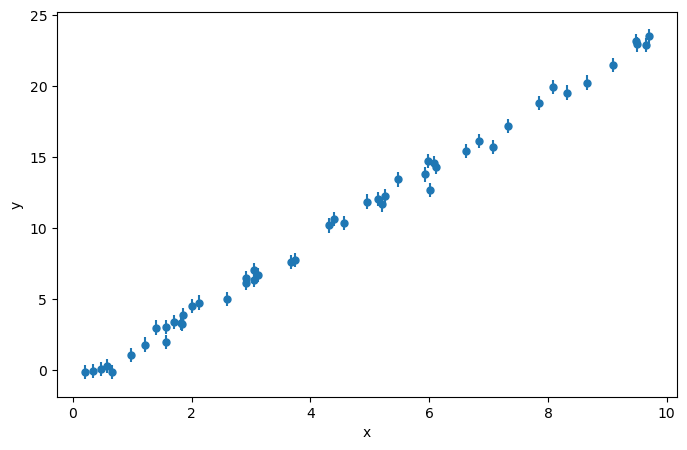

In [4]:

# Fix the random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for linear regression
true_m = 2.5   # True slope
true_b = -1.0  # True intercept
true_sigma = 0.5  # True standard deviation of the noise

N = 50  # Number of data points
x = np.sort(np.random.rand(N) * 10)  # Predictor values
y = true_m * x + true_b + np.random.normal(0, true_sigma, size=N)  # Observed values with noise

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.errorbar(x, y, yerr=true_sigma, fmt="o", markersize=5)
ax.set_xlabel("x")
ax.set_ylabel("y")

To do classical Bayesian inference, we need to define three functions: (1) a function that computes the prior probability density, (2) a function that defines the likelihood, and (3) a function that puts the two together into a posterior. 

Let's write those below:

In [5]:
# Define the prior probability function
def log_prior(theta):
    """
    Log-prior for parameters.
    We assume Gaussian priors for m and b, and a flat prior for log_sigma.

    Parameters
    -----------
    theta: iterable
        [m, b, log_sigma]

    Returns
    -------
    logp : float
        The log-prior 
    """
    m, b, log_sigma = theta
    if -10 < m < 10 and -10 < b < 10 and -5 < log_sigma < 1:
        return 0  # Normal(0, sqrt(10)) prior
    return -np.inf  # log(0)

# Define the likelihood function (log)
def log_likelihood(theta, x, y):
    """
    Log-likelihood of the data given the model parameters.
    """
    m, b, log_sigma = theta
    sigma = np.exp(log_sigma)  # Convert log_sigma back to sigma
    model = m * x + b
    return -0.5 * np.sum(((y - model) / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the posterior probability function (log)
def log_posterior(theta, x, y):
    """
    Combines the log-prior and log-likelihood to compute the log-posterior.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)


Now we can use Markov Chain Monte Carlo to sample the posterior. For ease of use, here we'll use the popular [`emcee`](https://emcee.readthedocs.io) package.

One thing to note: with Metropolis-Hastings MCMC, you usually run a small number of chains for a really long time (say 5-10). For emcee, you'll want more chains (here we've chosen 50), but you won't have to run them as long:

Running emcee sampler...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2621.89it/s]


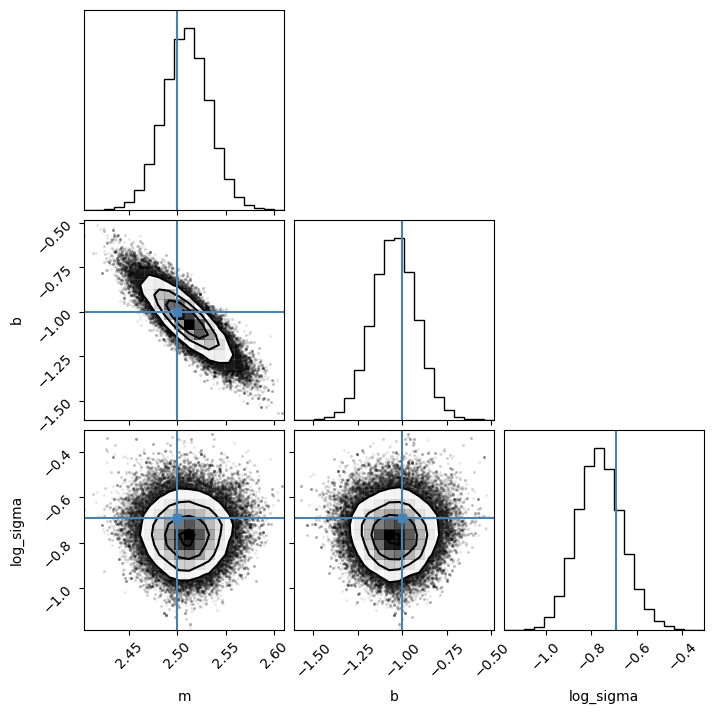

In [7]:
# Set up MCMC sampling using emcee
ndim = 3  # number of parameters: m, b, log_sigma
nwalkers = 50  # number of MCMC walkers (equivalent to chains)
nsteps = 3000  # number of steps per walker

# Initialize walkers in a Gaussian ball around the true parameters
initial = np.array([true_m, true_b, np.log(true_sigma)])
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))

# Run MCMC
print("Running emcee sampler...")
sampler.run_mcmc(pos, nsteps, progress=True)

# Extract the samples and discard burn-in
burn_in = 500
samples = sampler.get_chain(discard=burn_in, flat=True)

# Plot posterior distributions
fig = corner.corner(samples, labels=["m", "b", "log_sigma"], truths=[true_m, true_b, np.log(true_sigma)])
plt.show()


Okay, so that seems to broadly work.

# --- Second Example: Bayesian Linear Regression using Pyro and HMC ---

Now we repeat the same model using Pyro with Hamiltonian Monte Carlo:

In [9]:
# Prepare the data for Pyro: turn into tensors:
x_tensor = torch.tensor(x, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)


We define a function that encompasses the whole model in Pyro. For fun, we'll use a Half-Cauchy distribution for the prior for the error:

In [10]:
# Define the probabilistic model in Pyro
def model(x, y=None):
    """
    Bayesian linear regression model.
    """

    m = pyro.sample("m", dist.Uniform(-10, 10))  # sample from prior for slope
    b = pyro.sample("b", dist.Uniform(-10, 10))  # Prior for intercept
    sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))  # Prior for noise std

    mean = m * x + b  # Linear model

    # this tells Pyro that it should compute the product of the likelihoods
    # for each data point
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)  # Likelihood


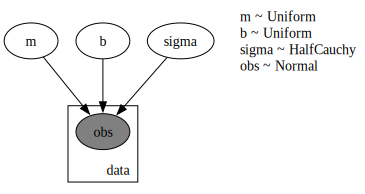

In [12]:
pyro.render_model(
    model,
    model_args=(x_tensor,y_tensor),
    render_distributions=True,
    render_params=True
)

In [13]:
# Use Hamiltonian Monte Carlo to sample from the posterior
hmc_kernel = HMC(model)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=500)

# Run inference
print("Running HMC with Pyro...")
mcmc.run(x_tensor, y_tensor)

# Get posterior samples
posterior_samples = mcmc.get_samples()


Running HMC with Pyro...


Sample: 100%|████████████████████████████████████████| 1500/1500 [02:11, 11.43it/s, step size=2.72e-01, acc. prob=0.959]                


In [14]:
import arviz as az

array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

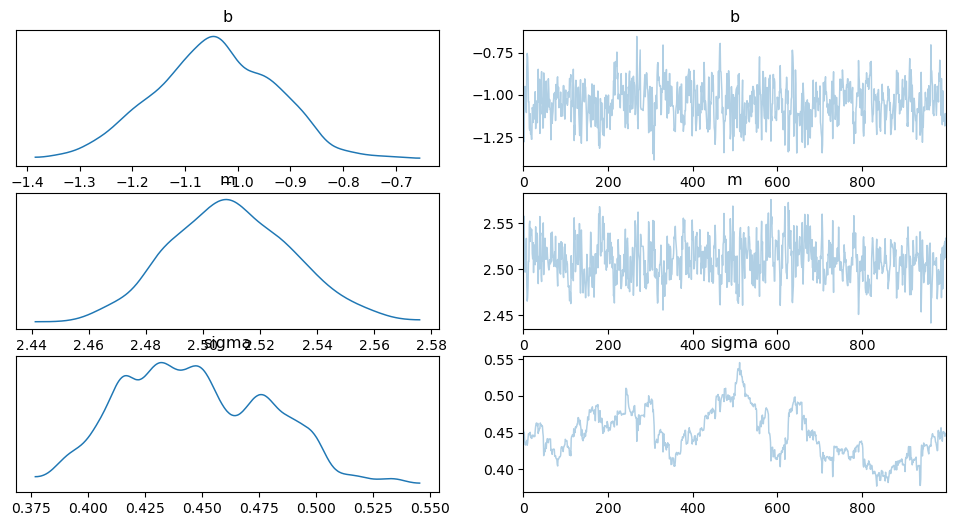

In [18]:
az.plot_trace(posterior_samples)

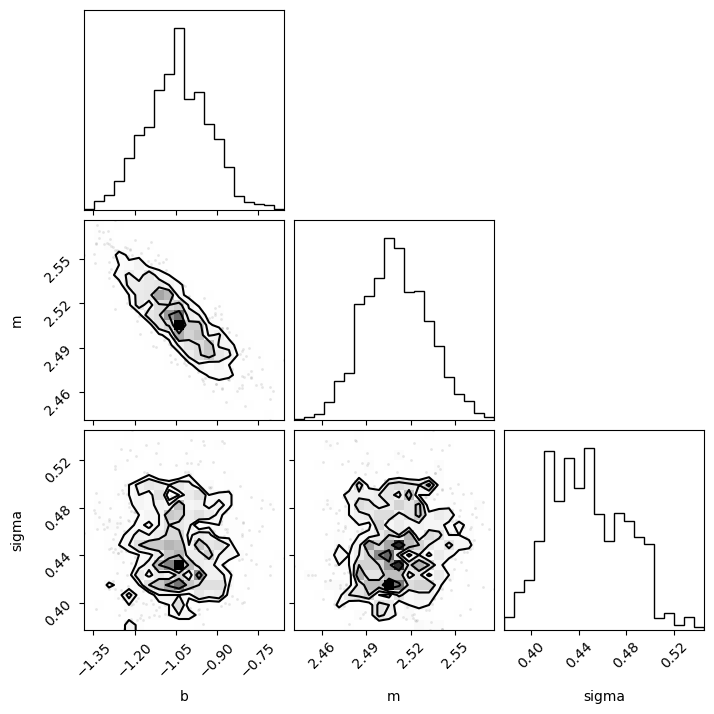

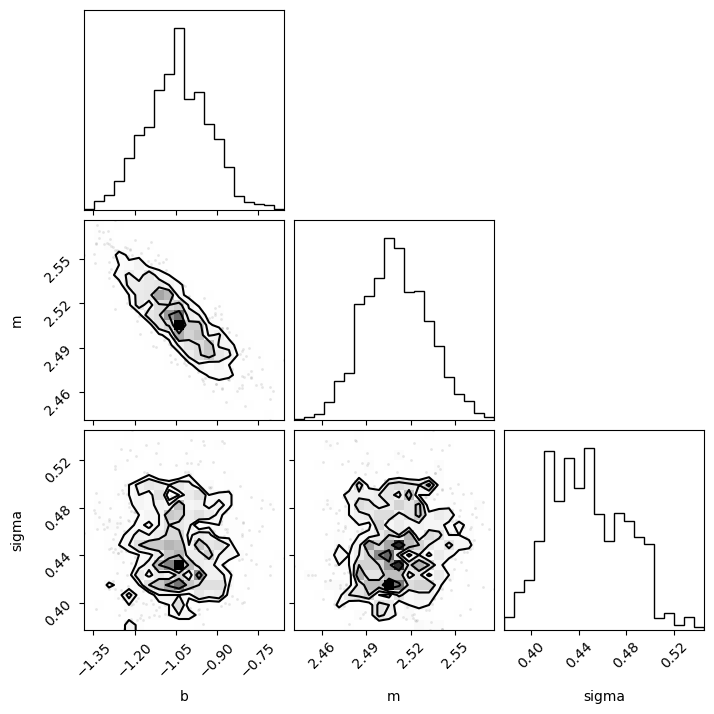

In [20]:
corner.corner(posterior_samples)